# Class-Adaptive Data Augmentation for Image Classification
### Purpose
While label-preserving property, class-specific augmentation(class별 적응형 augmentation 적용) through an optimization procedure to maximize the degree of transformation

- Data Augmentation 을 수행한 image가 다른 class를 갖게 된다면 오히려 해당 성능을 떨어지게 만들 수 있음
- 해당 연구는 Domain knowledge가 부족한 상태에서도, same manner가 아닌 class-adaptive augmentation을 수행하는 방법을 고안함
- Digit image 기반인 MINST and SVHN dataset을 통해 해당 연구를 수행함

해당 연구에서는 실험 senario로 세 가지 stage를 제안함<br>
stage_1) CNN training withhout data augmentation<br>
stage_2) optimization of class-specific augmentation polices while label-preserving property<br>
stage_3) CNN re-training with class-adaptive data augmentation

### Various Traditional Augmentation
1) Geometric transformation operations by changing the pixel positions<br>
2) Rotation, shifting, zooming, shearing, and flipping<br>
3) Photometric transformation - 각 색상에 대한 pixel 값을 변경(밝기 조절 포함)<br>
4) Combining two existing images, such as Mixup, CutMix, CutPaste

해당 연구에서는 1), 3) 대한 augmentation을 통해서 class-specific augmentation을 수행

\* 각 방식에 대한 참고. https://lcyking.tistory.com/entry/%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%A6%9D%EA%B0%95Data-Augmentation

The distribution determines the degree of transformation of the image(분포에 따라서 이미지의 변형 정도를 선택)<br>
too narrow - data augmentation의 효과를 뚜렷하게 확인할 수 없음<br>
too broad - class-preserving이 어려움<br>
즉, 적절한 분포를 선택하지 않으면 오히려 negative effect를 유발할 수 있음

최근 연구들은 이러한 분포에 대한 세팅을 automatically 설정하는 것에 집중

기존 연구들의 search space of an augmentation policy and hyperparameter에 대한 설정은 dataset-level 과 instance-level로 나뉜다

1) dataset-level approach<br>
- 주어진 데이터셋 전체에 대해 최적화되로록 증강 정책을 수립

2) instance-level approach<br>
- each instance(input)에 대해서 image-specific augmentation을 적용

이와 다르게 해당 연구에서는 class-specific augmentation policy를 수립<br>
기존 연구 방법과 다르게 방향이 가지는 차별점

1) dataset-level approach<br>
- class-preserving 상태에서 다양한 transformation을 적용할 수 있음

2) instance-level approach<br>
- single CNN을 사용함으로써 network cost의 최소화(memory)

### Methology
- 수식을 통한 구체적인 이해를 위해 Notion에 따로 정리하였음<br>
https://www.notion.so/Class-Adaptive-Data-Augmentation-for-Image-Classification-247d8518abea80e58c58cd03ca3264b6


### Experiments
dataset
- MNIST
- SVHN
- WM-811K 에 대해 진행 

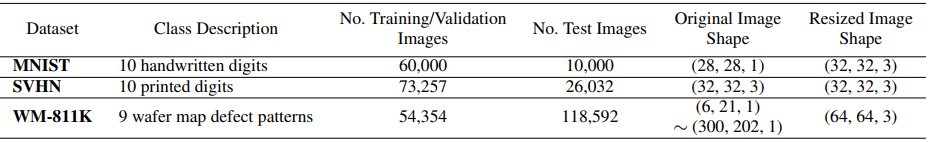

**CNN 구조**
- VGG(Batch Normalization 적용) / ResNet34 적용
- 두 모델 모두 완전연결층(fully-connected layer 제거)
- 출력층(Output layer)는 클래스 수에 맞게 노드 개수 설정
- VGG18의 경우 Flatten 대신 Global Average Pooling 적용

### Train 설정
**Stage_1**
- Train:Validation = 8:2
- Loss 함수: Categorical Cross-Entropy
- Optimizer: Adam
- Mini-batch size: 128
- L2 Regularization e^-4
- Augmentation decay gamma: 0.98
- Initial Learning rate: e^-4
- LR 감소 조건 -> Validation accuracy가 25 epoch 동안 향상이 없을 시 0.1 배로 감소
- Early Stopping 조건<br>
 1) 총 100 epoch 이후, validation accurcy가 50 epoch 동안 향상 없으면 종료<br>
 2) 또는 최대 500 epoch 도달 시 종료

**Stage_2**
- Table 1에 들어있는 10개의 transformation을 진행
- 초기 epsilon = 0.1 / lambda = 0.01 로 설정
- Bayesian Optimization
    - surrogate model: Gaussian Process + Matern kernel
    - Acuquistion function: Expected Improvement
    - 초기 랜덤 탐색 5회 + 최적화 단계 30회

**성능 평가**
- 지표: Test Set Classification Accuracy
- 모든 실험은 랜덤 시드 다르게 10회 독립 반복
- 결과는 평균 +- 표준편차로 보고 
- DatasetAdaptive-DA(ablaiton)/Without-DA/Baseline-DA/ClassAdaptive-DA 에 대한 비교를 통한 결과 제시

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torchvision import models
from torch.utils.data import DataLoader
from tqdm import tqdm